# Model Comparison Tests

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import time
from training_functions import *
import logging

In [3]:
logging.basicConfig(level=logging.INFO)

## Data exploration and Preprocessing

#### Get the data from ES and create a pandas dataframe

We take datapoints in the range of the 9th and 13th of June with a sample rate of 20. 

In [4]:
q_one = es_to_df(start_date="2020-06-09",end_date="2020-06-13", s_rate=20, tier="censhare", host='localhost', port=9200)
q_two = es_to_df(start_date="2020-06-09",end_date="2020-06-13", s_rate=20, tier="pic", host='localhost', port=9200)

INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.095s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.083s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.081s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.120s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.251s]
INFO:root:ES to Df: 1.02 time elapsed
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.115s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.697s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.679s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.138s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.224s]
INFO:root:ES to Df: 2.48 time elapsed


#### Overview of the changing queue size over time

In [5]:
q_one_size = q_one['size']
q_two_size = q_two['size']

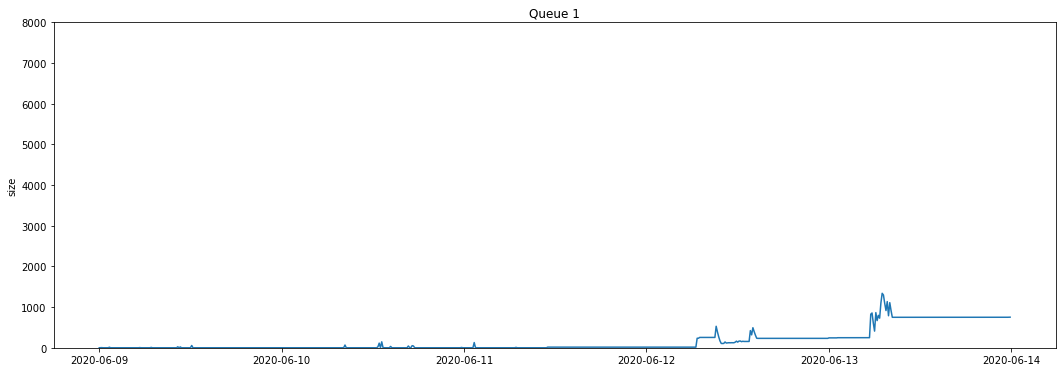

In [6]:
plt.figure(figsize=[5.98543*3,5.98543])
plt.title('Queue 1')
plt.ylabel('size')
plt.ylim(0,8000)
plt.plot(q_one_size)
#plt.savefig('q1jun.pdf')

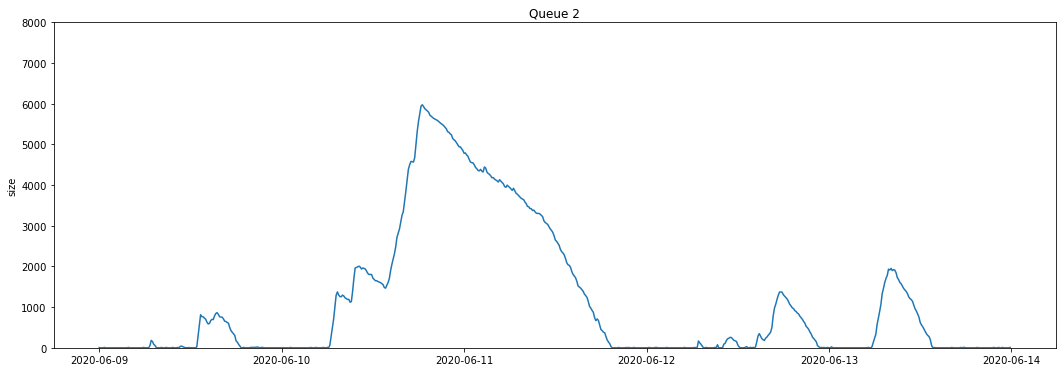

In [7]:
plt.figure(figsize=[5.98543*3,5.98543])
plt.title('Queue 2')
plt.ylabel('size')
plt.ylim(0,8000)
plt.plot(q_two_size)
#plt.savefig('q2jun.pdf')

#### Create the feature enriched dataset for each item

In [8]:
X, y, maxlen = create_dataset_train(q_one, q_two)

INFO:root:3215 items in the first and second queue
INFO:root:11177 items in the second queue only
INFO:root:14392 items in the whole dataset
INFO:root:Create dataset: 19.98 time elapsed


#### Overview of the samples

Create maxlenlist containing the maximum number of steps each sample is in the queue

In [9]:
maxlenlist, mean, median = get_max_len_list_mean_median(y)

Show the mean and median of the sample lengths

$$\textrm{mean}(x) = \dfrac{\sum\limits_{i=1}^N x_i}{N} = \frac{x_1 + x_2 + \cdot \cdot \cdot + x_N}{N} $$

$$\textrm{median}\left(x\right)
=\begin{cases}
  x_\frac{n+1}{2}                                    & n\text{ odd}\\
  \frac {1}{2}\left(x_{\frac{n}{2}} + x_{\frac{n}{2} + 1}\right) & n \text{ even}
\end{cases}$$

In [10]:
mean, median

(77, 35)

Show histogram of the distribution of each sample length

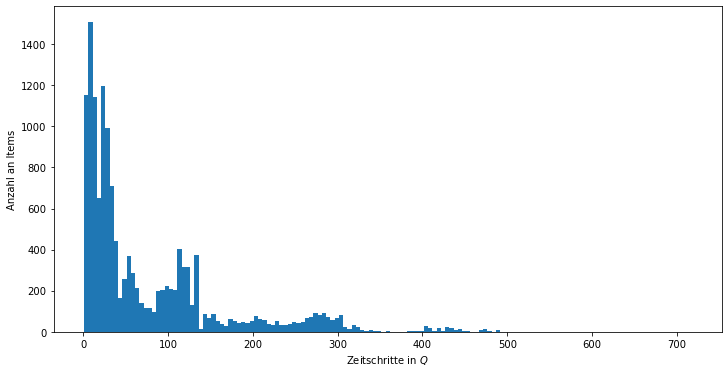

In [11]:
plt.figure(figsize=[5.98543*2,5.98543])
plt.hist(maxlenlist,bins=int(len(maxlenlist)/100))
plt.ylabel('Anzahl an Items')
plt.xlabel('Zeitschritte in $Q$')
#plt.savefig('histjun.pdf')
plt.show()

Show the most common occurence of lengths

In [12]:
from collections import Counter

In [13]:
#Counter(maxlenlist).most_common()

Head of an individual sample

In [14]:
X[0].head()

,1000329377,Q_size_one,Q_size_two,n_added_two,n_removed_two,Q_start
0,1,856,27,27,1,0
1,2,609,135,135,27,0
2,3,410,233,194,96,0
3,4,865,332,147,48,0
4,5,669,575,285,42,0


In [15]:
y[0].head()

,1000329377
0,10
1,9
2,8
3,7
4,6


#### Scaling

In [16]:
X_scaled, y_scaled = scale(X, y, start_date="2020-06-09",end_date="2020-06-13", 
                           epochs='50', steps='720', s_rate='20', model_name='test')

INFO:root:Scale: 69.59 time elapsed


#### Padding

In [17]:
X_train, X_test, y_train, y_test = pad_split(X_scaled, y_scaled, maxlen, test_size=0.3)

INFO:root:Pad Split: 0.30 time elapsed


In [18]:
X_train[0]

array([[-1.0377314 , -0.31592798,  0.04023176,  1.1239045 , -0.2030473 ,
         0.41861403],
       [-1.0262443 , -0.31592798,  0.09055709,  0.9836154 , -0.38650185,
         0.41861403],
       [-1.0147572 , -0.31592798,  0.17409715,  1.9188763 ,  0.1271709 ,
         0.41861403],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]], dtype=float32)

In [19]:
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = downsample(X_train, X_test, y_train, y_test, rate=0.8)

INFO:root:Downsample: 0.05 time elapsed


Shape of the trainings samples (number of samples, timesteps, features)

In [20]:
X_train_sampled.shape

(8025, 720, 6)

In [22]:
X_test_sampled.shape

(3482, 720, 6)

In [23]:
len(X_scaled)

14392

## LSTM

The following neural networks have all been tested over 50 epochs and with 25 neurons

In [24]:
# Build the model
n_steps = X_train_sampled.shape[1]  # number of steps
n_features = X_train_sampled.shape[2]  # number of features

# Create model layer
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_steps, n_features)))  # Masking Layer for padding
model.add(LSTM(25, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(25, return_sequences=True))
model.add(Dense(1, input_dim=20))  # Dense Layer to generate 1Dimensional Outputs
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Define CallBacks
early_stop = EarlyStopping(monitor='mae', mode='min', patience=10)
mcp_save = ModelCheckpoint(f'models/mcp_compare_lstm_2020-06-09_2020-06-13_50epochs_720steps_20srate.h5', 
                            save_best_only=True, monitor='mae', mode='min')

# Start training
model.fit(X_train_sampled, y_train_sampled, epochs=50, validation_split=0.2,
          callbacks=[early_stop, mcp_save])

# Save the model in models directory
model.save(f'models/compare_lstm_2020-06-09_2020-06-13_50epochs_720steps_20srate.h5')

Epoch 1/50
201/201 [==============================] - 121s 600ms/step - loss: 0.0611 - mae: 0.5719 - val_loss: 0.0532 - val_mae: 0.5038
Epoch 2/50
201/201 [==============================] - 116s 578ms/step - loss: 0.0516 - mae: 0.4837 - val_loss: 0.0493 - val_mae: 0.4674
Epoch 3/50
201/201 [==============================] - 116s 576ms/step - loss: 0.0496 - mae: 0.4643 - val_loss: 0.0480 - val_mae: 0.4552
Epoch 4/50
201/201 [==============================] - 114s 568ms/step - loss: 0.0488 - mae: 0.4571 - val_loss: 0.0466 - val_mae: 0.4412
Epoch 5/50
201/201 [==============================] - 114s 568ms/step - loss: 0.0471 - mae: 0.4412 - val_loss: 0.0459 - val_mae: 0.4346
Epoch 6/50
201/201 [==============================] - 114s 565ms/step - loss: 0.0468 - mae: 0.4382 - val_loss: 0.0455 - val_mae: 0.4308
Epoch 7/50
201/201 [==============================] - 113s 564ms/step - loss: 0.0460 - mae: 0.4313 - val_loss: 0.0449 - val_mae: 0.4256
Epoch 8/50
201/201 [============================

MAE        :  30.7
MAE Mean   :  81.59
MAE Median :  86.75


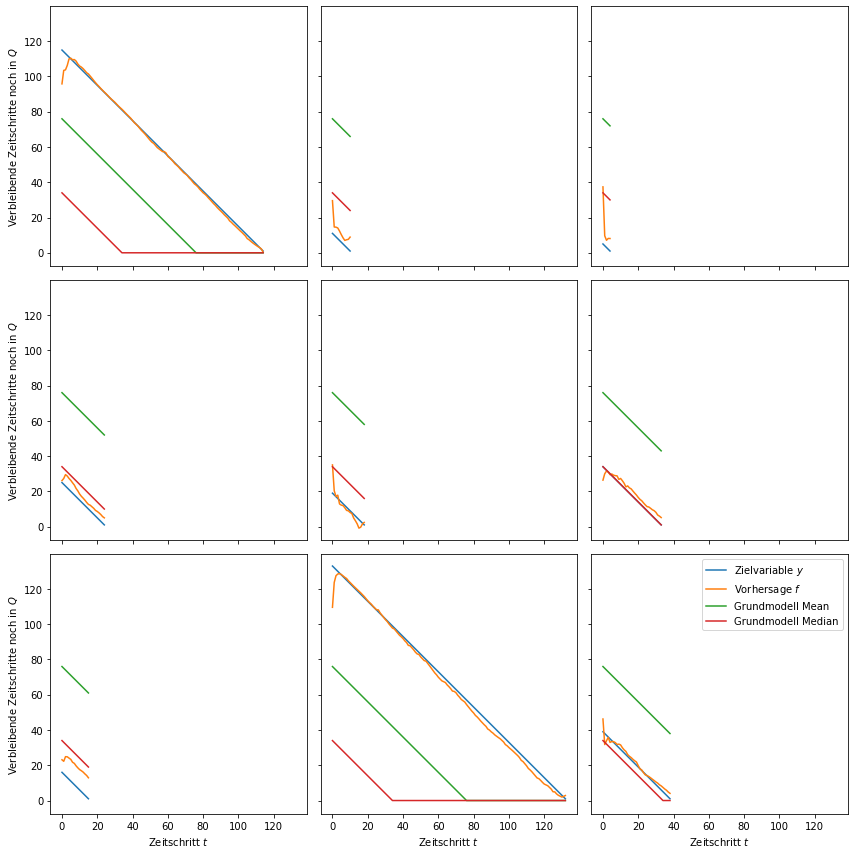

In [25]:
pred_mae(X_test_sampled, y_test_sampled, y, model='models/mcp_compare_lstm_2020-06-09_2020-06-13_50epochs_720steps_20srate.h5', 
         scaler_y='models/scalery_test_2020-06-09_2020-06-13_50epochs_720steps_20srate.p', n_plots=3, seed=1, model_name='LSTM',
         save_fig=True)

## GRU

In [26]:
from keras.layers import GRU

In [27]:
# Build the model
n_steps = X_train_sampled.shape[1]  # number of steps
n_features = X_train_sampled.shape[2]  # number of features

# Create model layer
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_steps, n_features)))  # Masking Layer for padding
model.add(GRU(25, return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(25, return_sequences=True))
model.add(Dense(1, input_dim=20))  # Dense Layer to generate 1Dimensional Outputs
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Define CallBacks
early_stop = EarlyStopping(monitor='mae', mode='min', patience=10)
mcp_save = ModelCheckpoint(f'models/mcp_compare_gru_2020-06-09_2020-06-13_50epochs_720steps_20srate.h5', 
                            save_best_only=True, monitor='mae', mode='min')

# Start training
model.fit(X_train_sampled, y_train_sampled, epochs=50, validation_split=0.2,
          callbacks=[early_stop, mcp_save])

# Save the model in models directory
model.save(f'models/compare_gru_2020-06-09_2020-06-13_50epochs_720steps_20srate.h5')

Epoch 1/50
201/201 [==============================] - 118s 587ms/step - loss: 0.0641 - mae: 0.6006 - val_loss: 0.0550 - val_mae: 0.5210
Epoch 2/50
201/201 [==============================] - 116s 576ms/step - loss: 0.0530 - mae: 0.4966 - val_loss: 0.0507 - val_mae: 0.4808
Epoch 3/50
201/201 [==============================] - 116s 577ms/step - loss: 0.0504 - mae: 0.4722 - val_loss: 0.0485 - val_mae: 0.4594
Epoch 4/50
201/201 [==============================] - 116s 577ms/step - loss: 0.0486 - mae: 0.4550 - val_loss: 0.0465 - val_mae: 0.4409
Epoch 5/50
201/201 [==============================] - 116s 577ms/step - loss: 0.0474 - mae: 0.4437 - val_loss: 0.0460 - val_mae: 0.4360
Epoch 6/50
201/201 [==============================] - 115s 571ms/step - loss: 0.0470 - mae: 0.4397 - val_loss: 0.0455 - val_mae: 0.4308
Epoch 7/50
201/201 [==============================] - 115s 571ms/step - loss: 0.0462 - mae: 0.4331 - val_loss: 0.0455 - val_mae: 0.4307
Epoch 8/50
201/201 [============================

MAE        :  30.99
MAE Mean   :  81.59
MAE Median :  86.75


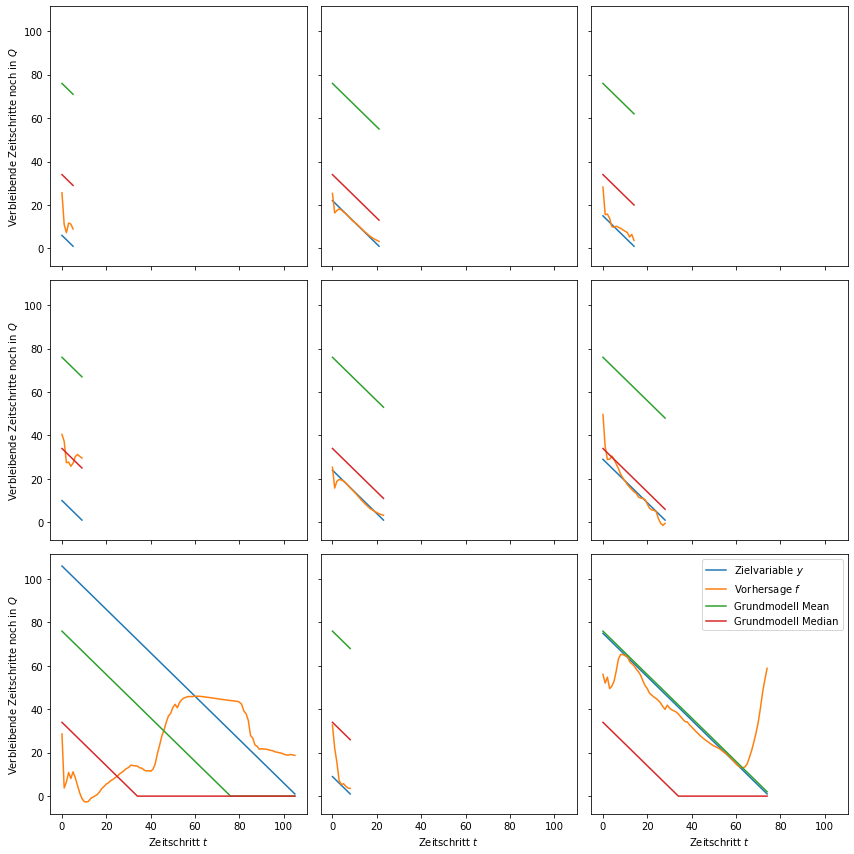

In [28]:
pred_mae(X_test_sampled, y_test_sampled, y, model='models/mcp_compare_gru_2020-06-09_2020-06-13_50epochs_720steps_20srate.h5', 
         scaler_y='models/scalery_test_2020-06-09_2020-06-13_50epochs_720steps_20srate.p', n_plots=3, seed=2, model_name='GRU',
         save_fig=False)

## SimpleRNN

In [29]:
from keras.layers import SimpleRNN

In [30]:
# Build the model
n_steps = X_train_sampled.shape[1]  # number of steps
n_features = X_train_sampled.shape[2]  # number of features

# Create model layer
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_steps, n_features)))  # Masking Layer for padding
model.add(SimpleRNN(25, return_sequences=True))
model.add(Dropout(0.1))
model.add(SimpleRNN(25, return_sequences=True))
model.add(Dense(1, input_dim=20))  # Dense Layer to generate 1Dimensional Outputs
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Define CallBacks
early_stop = EarlyStopping(monitor='mae', mode='min', patience=10)
mcp_save = ModelCheckpoint(f'models/mcp_compare_srnn_2020-06-09_2020-06-13_50epochs_720steps_20srate.h5', 
                            save_best_only=True, monitor='mae', mode='min')

# Start training
model.fit(X_train_sampled, y_train_sampled, epochs=50, validation_split=0.2,
          callbacks=[early_stop, mcp_save])

# Save the model in models directory
model.save(f'models/compare_srnn_2020-06-09_2020-06-13_50epochs_720steps_20srate.h5')

Epoch 1/50
201/201 [==============================] - 66s 328ms/step - loss: 0.0652 - mae: 0.6109 - val_loss: 0.0554 - val_mae: 0.5249
Epoch 2/50
201/201 [==============================] - 66s 326ms/step - loss: 0.0567 - mae: 0.5310 - val_loss: 0.0528 - val_mae: 0.4999
Epoch 3/50
201/201 [==============================] - 65s 325ms/step - loss: 0.0563 - mae: 0.5273 - val_loss: 0.0528 - val_mae: 0.4999
Epoch 4/50
201/201 [==============================] - 65s 324ms/step - loss: 0.0532 - mae: 0.4985 - val_loss: 0.0499 - val_mae: 0.4730
Epoch 5/50
201/201 [==============================] - 65s 324ms/step - loss: 0.0555 - mae: 0.5195 - val_loss: 0.0542 - val_mae: 0.5135
Epoch 6/50
201/201 [==============================] - 65s 323ms/step - loss: 0.0529 - mae: 0.4954 - val_loss: 0.0499 - val_mae: 0.4730
Epoch 7/50
201/201 [==============================] - 65s 323ms/step - loss: 0.0511 - mae: 0.4790 - val_loss: 0.0485 - val_mae: 0.4600
Epoch 8/50
201/201 [==============================] - 6

MAE        :  34.22
MAE Mean   :  81.59
MAE Median :  86.75


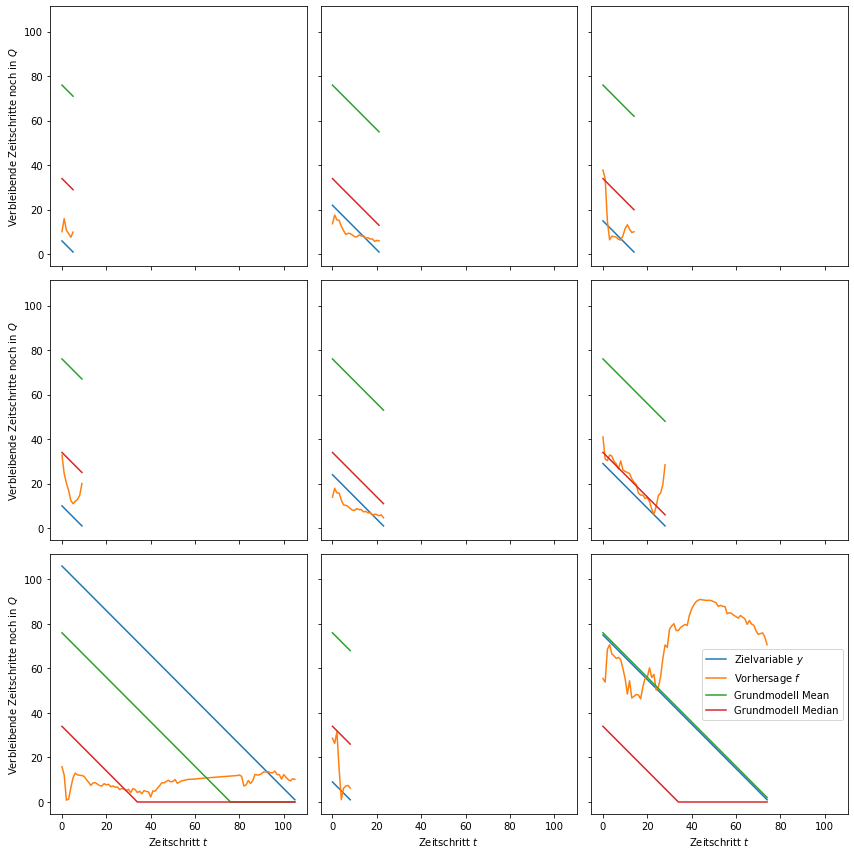

In [31]:
pred_mae(X_test_sampled, y_test_sampled, y, model='models/mcp_compare_srnn_2020-06-09_2020-06-13_50epochs_720steps_20srate.h5', 
         scaler_y='models/scalery_test_2020-06-09_2020-06-13_50epochs_720steps_20srate.p', n_plots=3, seed=2, model_name='SRNN',
         save_fig=False)

## Preprocessing Supervised Models

In [32]:
from sklearn.model_selection import train_test_split

def split_train_test(X, y, **kwargs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, **kwargs)
    X_train = np.vstack([x.values for x in X_train])
    X_test = np.vstack([x.values for x in X_test])
    y_train = np.concatenate([y.values for y in y_train])
    y_test = np.concatenate([y.values for y in y_test])
    return X_train, X_test, y_train, y_test

In [33]:
X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.3, shuffle=False)

In [34]:
X_train.shape

(741665, 6)

In [35]:
X_train[0], y_train[0]

(array([  1, 856,  27,  27,   1,   0], dtype=int64), array([10], dtype=int64))

## Scaling

In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, r2_score
from sklearn import metrics

def mape(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae_score(y_test, pred_test, output=True):
    mae = mean_absolute_error(y_test, pred_test)
    return mae

## Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression
import math

In [40]:
model_lr = LinearRegression(fit_intercept=True)

In [41]:
model_lr.fit(X_train, y_train)

LinearRegression()

In [42]:
pred = model_lr.predict(X_test)

In [43]:
get_mae_score(y_test, pred)

61.193807759788115

In [44]:
pred[:10]

array([[93.62799653],
       [92.82996688],
       [80.4392093 ],
       [93.18228615],
       [93.77554931],
       [93.99756247],
       [87.04153689],
       [86.72704029],
       [95.56111461],
       [93.60568521]])

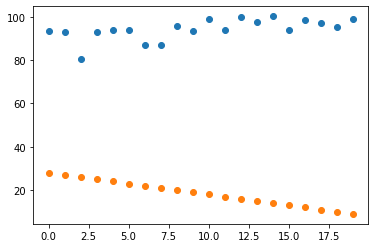

In [45]:
plt.scatter(range(20), pred[:20])
plt.scatter(range(20), y_test[:20])

## Decision Trees

In [46]:
from sklearn.tree import DecisionTreeRegressor

In [47]:
model_dt = DecisionTreeRegressor(random_state=0)

In [48]:
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [49]:
pred = model_dt.predict(X_test)

In [50]:
get_mae_score(y_test, pred)

35.18919789251589

In [51]:
pred[:10]

array([28., 27., 26., 25., 24., 23., 22., 21., 20., 19.])

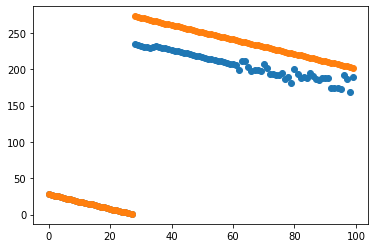

In [52]:
plt.scatter(range(100), pred[:100])
plt.scatter(range(100), y_test[:100])